<a href="https://colab.research.google.com/github/vnasserb/Desafio-FieldPRO/blob/main/Desafio_FieldPRO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação de Bibliotecas**

In [ ]:
!pip install pyod

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pyod.models.knn import KNN
from math import floor

# **Carregamento dos dados**

## **Estação Convencional**

In [31]:
dfEstacaoConvencional = pd.read_csv("Estacao_Convencional.csv").iloc[:,1:]
dfSensor = pd.read_csv("Sensor_FieldPRO.csv").iloc[:,1:]

In [32]:
dfEstacaoConvencional.rename(columns = {'data': 'Data', 'Hora (Brasília)': 'Hora'}, inplace = True)

## **Dados do sensor**

In [33]:
def extraiData(colunaData):
  data = colunaData.split("T")[0].split("-")
  dia, mes, ano = data[2], data[1], data[0]

  return ano + "-" + mes + "-" + dia

def extraiHora(colunaData):
  horario = colunaData.split("T")[1][:-1]
  return horario

funcaoData = np.vectorize(extraiData)
funcaoHora = np.vectorize(extraiHora)

dfSensor['Data'] = funcaoData(dfSensor['Datetime – utc'].values)
dfSensor['Hora'] = funcaoHora(dfSensor['Datetime – utc'].values)

## **União das bases de dados**

In [34]:
df = dfSensor.merge(dfEstacaoConvencional, how = 'inner', on = ['Data', 'Hora'])
df.drop(['Datetime – utc', 'Data', 'Hora'], inplace = True, axis = 1)

X = df.iloc[:, 0:-1]
Y = df.iloc[:, -1]

# **Tratamento de valores nulos**

In [35]:
def tratarNan(df):
  dfNovo = df.copy()
  colunas = df.isnull().sum().index
  quantidadesNan = df.isnull().sum().values
  for col in range(len(colunas)):
    if quantidadesNan[col] == 0:
      continue
    else:
      colunaEscolhida = df.iloc[:, col].values
      for elemento in range(len(colunaEscolhida)):
        if not np.isnan(colunaEscolhida[elemento]):
          continue
        if elemento == 0:
          colunaEscolhida[elemento] = colunaEscolhida[elemento + 1]
        elif elemento == len(colunaEscolhida) - 1:
          colunaEscolhida[elemento] = colunaEscolhida[elemento - 1]
        else:
          colunaEscolhida[elemento] = 0.5 * (colunaEscolhida[elemento - 1] + colunaEscolhida[elemento + 1])

    dfNovo[colunas[col]] = colunaEscolhida

  return dfNovo

In [36]:
X = tratarNan(X)

# **Padronização dos dados**

In [37]:
ss = StandardScaler()
X_Padronizado = ss.fit_transform(X)

# **Detecção de Outliers**

In [38]:
detectorOutliers = KNN()
detectorOutliers.fit(X_Padronizado)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [39]:
outliers = detectorOutliers.labels_

In [40]:
xSemOut = []
ySemOut = []

for amostra in range(len(X_Padronizado)):
  if outliers[amostra] == 0:
    xSemOut.append(X_Padronizado[amostra])
    ySemOut.append(Y[amostra])
  else:
    continue

# **Divisão em treino e teste**

In [41]:
xTreino, xTeste, yTreino, yTeste = train_test_split(xSemOut, ySemOut, test_size=0.3)

# **Criação do modelo de regressão**

In [42]:
regressor = LinearRegression()
regressor.fit(xTreino, yTreino)

LinearRegression()

# **Comparação entre os valores reais e os previstos pelo modelo**

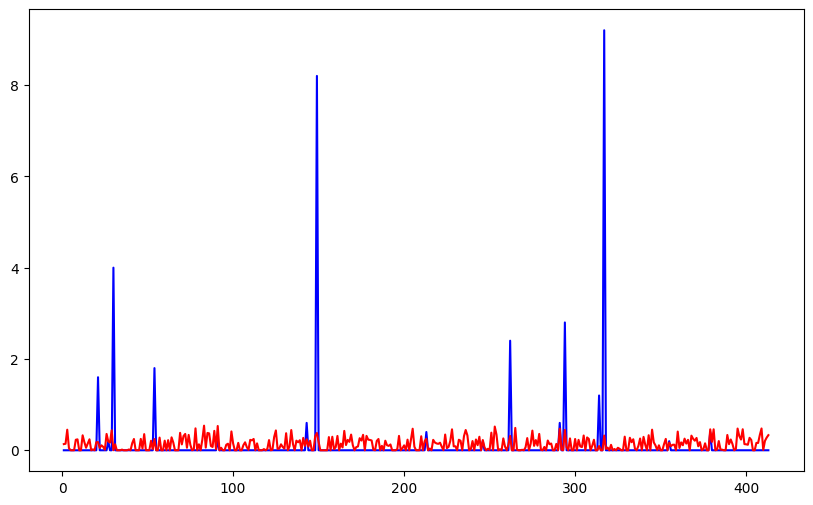

In [43]:
def ajeitaValores(valores):
  indicesPositivos = np.where(valores > 0)[0]
  valoresFinais = []

  for valor in range(len(valores)):
    if valor in indicesPositivos:
      valoresFinais.append(valores[valor])
    else:
      valoresFinais.append(0)
  return valoresFinais

indices = np.arange(1,len(yTeste) + 1, 1)
previsoes = ajeitaValores(regressor.predict(xTeste))
plt.figure(figsize = (10,6))
plt.plot(indices, yTeste, color = 'blue')
plt.plot(indices, previsoes, color = 'red')